In [1]:
import os
import time
# import itertools

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
# # from adjustText import adjust_text
# from statannotations.Annotator import Annotator

# # import warnings
# from scipy.stats import chi2_contingency, fisher_exact, f_oneway, tukey_hsd, kruskal


In [2]:
sns.set_style("whitegrid")

In [3]:
import sys
import importlib
sys.path.append('/mnt/d/GoTx_Folder/src')
# from a2ihelper import call_reditools,
# import a2ihelper
# importlib.reload(a2ihelper)
import a2ihelper as a2i


# a2iHelper demonstration

## Get expression data from public study GSE145011

In [4]:
df_genes_demo = pd.read_excel('/mnt/e/editing_methods/PRJNA605715_GSE145011/mmc3.xlsx', sheet_name='Table S3b', header=1)
df_genes_demo_en = pd.read_excel('/mnt/e/editing_methods/PRJNA605715_GSE145011/mmc3.xlsx', sheet_name='Table S3a', header=1)
df_genes_demo_en_2 = pd.read_csv('/mnt/e/editing_methods/PRJNA605715_GSE145011/mmc4.txt', sep=' ')

df_genes_demo['count'] = df_genes_demo.gene.map(dict(dict(df_genes_demo_en.groupby('Gene').count().Region)))
df_genes_demo['count2'] = df_genes_demo.gene.map(dict(df_genes_demo_en_2.groupby('SYMBOL').count().sort_values('R_P', ascending=False).R_P))
df_genes_demo['count3'] = df_genes_demo['count'].fillna(df_genes_demo['count2'])
df_genes_demo['count3'] = df_genes_demo['count3'].fillna(df_genes_demo['count'])
df_genes_demo['-log10(fdr)'] = -np.log10(df_genes_demo['p.adj'])

/tmp/ipykernel_262467/3172618387.py:3: DtypeWarning: Columns (32) have mixed types. Specify dtype option on import or set low_memory=False.
  df_genes_demo_en_2 = pd.read_csv('/mnt/e/editing_methods/PRJNA605715_GSE145011/mmc4.txt', sep=' ')


In [5]:
df_genes_demo.head()

,gene,.y.,group1,group2,p,p.adj,p.format,p.signif,method,count,count2,count3,-log10(fdr)
0,FAM129C,value,Ctrl,Cases,1.690000e+00,3.400000e-13,1.7e-14,****,Wilcoxon,NaN,NaN,NaN,12.468521
1,CCAR1,value,Ctrl,Cases,4.540000e+05,2.500000e-07,4.5e-08,****,Wilcoxon,NaN,7.0,7.0,6.602060
2,IKZF3,value,Ctrl,Cases,1.020000e+06,6.300000e-08,1.0e-08,****,Wilcoxon,34.0,16.0,34.0,7.200659
3,NPLOC4,value,Ctrl,Cases,2.220000e-03,9.900000e-16,< 2e-16,****,Wilcoxon,NaN,4.0,4.0,15.004365
4,MDM4,value,Ctrl,Cases,1.810000e+03,1.900000e-10,1.8e-11,****,Wilcoxon,38.0,2.0,38.0,9.721246


## Get the 100th most relevant genes in the public dataset as an example and the annotation to get coordinates

In [6]:
gene_list = df_genes_demo.sort_values(['count2','-log10(fdr)'], ascending=False).head(100).gene.tolist()+['ADAR','UBR4','WDR12','APOL1']
path_ref_annotation='/mnt/e/editing_methods/PRJNA605715_GSE145011/gencode.v44.basic.annotation.gtf'

In [7]:
len(gene_list)

104

## Get coordinates with get_genes_positions function

In [13]:
t1 = time.time()
gene_coord = a2i.call_reditools2.get_genes_positions(gene_list, path_ref_annotation, gzip_file=False)
t2 = time.time()
print(int((t2-t1)//60), (t2-t1)%60, sep=':')

0:19.60171389579773


In [14]:
print(dict(list(gene_coord.items())[:2]), '...', dict(list(gene_coord.items())[-2:]))

{'MRPL20': 'chr1:1401909-1407293', 'ATAD3B': 'chr1:1471765-1497848'} ... {'GNL3L': 'chrX:54530183-54621521', 'MAGT1': 'chrX:77825747-77899271'}


## Call reditools2

### Call samtools index
Before calling reditools2, having the index file for each bam file is mandatory. It can be done with the bash script below.

In [ ]:
# %bash
# #!/bin/bash

# pathIn="/mnt/d/rna_editing/" #path with the bams files

# arr=(${pathIn}*ready.bam)
# for filename in ${arr[@]##*/}; do
#     echo ${filename}
#     time samtools index ${pathIn}${filename}
# done
# echo "BAI files DONE!"

### Preparing the arguments for the run_per_gene_position_list function

In [15]:
genes_positions = gene_coord.values()
in_bam_file_list = ['/mnt/e/editing_methods/PRJNA605715_GSE145011/star_1pass/'+f for f in os.listdir('/mnt/e/editing_methods/PRJNA605715_GSE145011/star_1pass/') if f.endswith('bam')]
path_out_res = '/mnt/e/editing_methods/PRJNA605715_GSE145011/RES/'
ref_genome_file = '/mnt/e/reference_files/GRCh38.p14.genome.fa'
path_reditools = '/mnt/d/reditools2.0/src/cineca/'
reditools_options = ''
# reditools_options = '--strict' use strict in case only editing sites are in the output
n_jobs = 10

In [ ]:
t1 = time.time()
for in_bam_file in in_bam_file_list:
    a2i.call_reditools2.run_per_gene_position_list(genes_positions, in_bam_file, path_out_res, ref_genome_file, path_reditools, reditools_options=reditools_options, n_jobs=n_jobs)
    print('#',end=' ')
t2 = time.time()
print(int((t2-t1)//60), (t2-t1)%60, sep=':')

### Preparing the metadata files to integrate

In [8]:
import gzip

t1 = time.time()
meta_names = ['!Sample_title','!Sample_geo_accession', '!Sample_source_name_ch1', '!Sample_source_name_ch2','!Sample_characteristics_ch1']
gse_meta = open('/mnt/e/editing_methods/PRJNA605715_GSE145011/'+'PRJNA605715_GSE145011_meta.tsv', 'w')

with gzip.open('/mnt/e/editing_methods/PRJNA605715_GSE145011/'+'GSE145011_series_matrix.txt.gz') as gse:
    expr_flag = False
    for line in gse:
        if line.decode().split('\t')[0] in meta_names:            
            gse_meta.write(line.decode())
gse_meta.close()
t2 = time.time()
print(int((t2-t1)//60), (t2-t1)%60, sep=':')

0:0.38611555099487305


In [9]:
meta_1 = pd.read_csv('/mnt/e/editing_methods/PRJNA605715_GSE145011/PRJNA605715_GSE145011_meta.tsv', sep='\t', index_col=0).T.reset_index()#.set_index('!Sample_geo_accession')
meta_1[['cell_line','condition']] = meta_1['index'].str.split('_', expand=True)
# meta_1 = meta_1.drop(['index'], axis=1)
meta_1.columns = ['cell_line_condition','geo_acc','1','genotype','tissue','4','cell_line', 'condition']
meta_1 = meta_1.drop(['1', '4'], axis=1)
meta_1['genotype'] = meta_1['genotype'].str.replace('genotype: ','')
meta_1['tissue'] = meta_1['tissue'].str.replace('tissue: ','')

meta_2 = pd.read_csv('/mnt/e/editing_methods/PRJNA605715_GSE145011/SraRunTable.txt')[['Run','Sample Name']]
meta_2.columns = ['Run','geo_acc']

meta_1 = meta_1.merge(meta_2, on='geo_acc')

In [10]:
meta_1

,cell_line_condition,geo_acc,genotype,tissue,cell_line,condition,Run
0,A549_WT1,GSM4304246,wild type,Lung carcinoma,A549,WT1,SRR11050913
1,A549_WT2,GSM4304247,wild type,Lung carcinoma,A549,WT2,SRR11050914
2,A549_WT3,GSM4304248,wild type,Lung carcinoma,A549,WT3,SRR11050915
3,A549_KO1,GSM4304249,ADAR1-/-,Lung carcinoma,A549,KO1,SRR11050916
4,A549_KO2,GSM4304250,ADAR1-/-,Lung carcinoma,A549,KO2,SRR11050917
5,A549_KO3,GSM4304251,ADAR1-/-,Lung carcinoma,A549,KO3,SRR11050918
6,RC-K8_WT1,GSM4304252,wild type,B-cell lymphoma,RC-K8,WT1,SRR11050919
7,RC-K8_WT2,GSM4304253,wild type,B-cell lymphoma,RC-K8,WT2,SRR11050920
8,RC-K8_WT3,GSM4304254,wild type,B-cell lymphoma,RC-K8,WT3,SRR11050921
9,RC-K8_KO1,GSM4304255,ADAR1-/-,B-cell lymphoma,RC-K8,KO1,SRR11050922


### Integrating the file name, coordinates, and SRA code to the metadata.
The metadata must contain the follow information in the same order:

- First column: Full path file names of REDItools2 results tables
- Second column: Samples names
- Third column: region (gene symbol)
- Fourth column: conditions

In [16]:
meta = pd.DataFrame(os.listdir(path_out_res))
meta.columns = ['file_name']
meta[['Run','coord']] = meta.file_name.str.split('_Aligned.sortedByCoord.out.bam_', n=1, expand=True)
meta['coord'] = meta.coord.str.replace('_RES.tsv','')
meta['coord'] = meta.coord.str.replace('_',':', n=1)
meta['coord'] = meta.coord.str.replace('_','-')
meta['region'] = meta['coord'].map({value:key for key,value in gene_coord.items()})
meta['file_name'] = path_out_res+meta.file_name

meta = meta.merge(meta_1, on='Run')

meta = meta[['file_name', 'Run', 'region', 'genotype', 'cell_line_condition', 'condition','cell_line',  'coord']]
meta

,file_name,Run,region,genotype,cell_line_condition,condition,cell_line,coord
0,/mnt/e/editing_methods/PRJNA605715_GSE145011/R...,SRR11050913,WDFY4,wild type,A549_WT1,WT1,A549,chr10:48684873-48982956
1,/mnt/e/editing_methods/PRJNA605715_GSE145011/R...,SRR11050913,C11orf58,wild type,A549_WT1,WT1,A549,chr11:16613132-16758340
2,/mnt/e/editing_methods/PRJNA605715_GSE145011/R...,SRR11050913,EP400,wild type,A549_WT1,WT1,A549,chr12:131949942-132080460
3,/mnt/e/editing_methods/PRJNA605715_GSE145011/R...,SRR11050913,POLE,wild type,A549_WT1,WT1,A549,chr12:132623753-132687376
4,/mnt/e/editing_methods/PRJNA605715_GSE145011/R...,SRR11050913,GOLGA3,wild type,A549_WT1,WT1,A549,chr12:132768902-132829143
...,...,...,...,...,...,...,...,...
1243,/mnt/e/editing_methods/PRJNA605715_GSE145011/R...,SRR11050924,SYAP1,ADAR1-/-,RC-K8_KO3,KO3,RC-K8,chrX:16719612-16765340
1244,/mnt/e/editing_methods/PRJNA605715_GSE145011/R...,SRR11050924,SLC9A7,ADAR1-/-,RC-K8_KO3,KO3,RC-K8,chrX:46599251-46759118
1245,/mnt/e/editing_methods/PRJNA605715_GSE145011/R...,SRR11050924,RBM3,ADAR1-/-,RC-K8_KO3,KO3,RC-K8,chrX:48574449-48581162
1246,/mnt/e/editing_methods/PRJNA605715_GSE145011/R...,SRR11050924,GNL3L,ADAR1-/-,RC-K8_KO3,KO3,RC-K8,chrX:54530183-54621521


### Merging all editing files to perform analysis

In [17]:
time1 = time.time()
df, df_a, df_g, region_list = a2i.editing.merge_files_all_regions(meta)#[meta.cell_line=='RC-K8'])
time2 = time.time() - time1
print(int((t2-t1)//60), (t2-t1)%60, sep=':')

38.528905153274536 s,  0.6421484192212422 min


### Applying filter by nan values, zeros and 100% of editing.

In [19]:
df = a2i.editing.filter_positions(df, nan_filter=True, nan_filter_limit=4, zero_filter=False, hundred_filter=False,  per_condition=False)

In [20]:
df

,11_16744616,11_16744620,11_16744631,11_16744632,11_16744675,11_16748108,11_16748111,11_16748122,11_16748149,11_16752815,...,X_77828545,X_77828723,X_77828981,X_77856805,X_77857415,X_77875460,X_77826960,X_77828141,region,genotype
SRR11050913,0.142399,0.037147,0.032841,0.064267,0.379507,0.237741,0.157580,0.056867,0.080150,0.105152,...,0.767263,0.815661,0.534759,0.760456,0.168067,0.564972,NaN,NaN,several,wild type
SRR11050914,0.175850,0.030950,0.027902,0.054585,0.207523,0.240038,0.228542,NaN,NaN,0.138281,...,1.250000,NaN,0.628931,1.890034,0.270636,0.486027,0.414938,0.896057,several,wild type
SRR11050915,0.033311,0.104493,0.062696,0.030960,0.352338,0.271493,0.324254,0.029011,NaN,0.028090,...,0.210970,NaN,0.465116,1.214575,0.949367,0.154321,0.599700,0.218341,several,wild type
SRR11050916,0.058309,NaN,0.053576,0.052673,0.425000,0.140056,0.098256,NaN,NaN,0.171380,...,NaN,0.548246,0.208333,1.144492,0.352526,0.110254,0.527426,0.320000,several,ADAR1-/-
SRR11050917,0.087642,NaN,0.025974,NaN,0.405922,0.313269,0.256949,0.041580,0.020149,0.121065,...,NaN,0.232019,1.399491,0.274348,0.722892,0.225225,0.092678,0.339559,several,ADAR1-/-
SRR11050918,0.061920,0.032175,0.028114,NaN,0.501379,0.162262,0.247341,0.066372,0.021286,0.170648,...,NaN,0.623053,0.923788,0.928382,0.814901,0.222717,0.214133,0.182815,several,ADAR1-/-
SRR11050919,0.127470,0.048457,0.104337,0.058858,0.284136,0.154655,0.016611,0.030148,0.014529,0.107444,...,11.111111,0.796813,1.388889,NaN,NaN,0.166667,0.492611,NaN,several,wild type
SRR11050920,0.085161,0.022134,0.102145,0.060289,0.193966,0.041434,0.088909,0.039308,0.037230,0.128488,...,12.857143,0.440529,2.083333,NaN,0.446429,0.202429,NaN,0.400000,several,wild type
SRR11050921,0.045086,0.069573,0.064921,0.042735,0.046555,0.133067,0.023557,0.043169,0.020231,0.121729,...,13.106796,0.450450,NaN,NaN,0.257069,NaN,1.315789,NaN,several,wild type
SRR11050922,0.053807,0.111235,NaN,0.078616,0.320793,0.084986,0.149076,0.080150,0.025132,0.073892,...,0.403226,NaN,NaN,0.526316,NaN,NaN,0.401606,NaN,several,ADAR1-/-


## Statistics for frequency data

### Anova tukey
The funtion anova_tukey_test returns the p-values for ANOVA test.

In [21]:
df_pv = a2i.stats.anova_tukey_test(df, only_pvalue=True, pvalue_filter_limit_anova=.05, pvalue_filter_limit_tukey=.05, return_only_significant=True)
df_pv

/mnt/d/GoTx_Folder/src/a2ihelper/stats.py:141: ConstantInputWarning: Each of the input arrays is constant; the F statistic is not defined or infinite
  aux_aov = f_oneway(*data_by_condition)


coord,12_98599984,17_80353632,19_41861150,19_41861168,19_55386433,19_55386578,19_55388245,20_3867545,2_206144963,3_45680382,5_172952431,7_44799741,7_44801375,7_44801505,X_48576551,X_48577089,X_48577987,X_77827544,X_77828394
tests,,,,,,,,,,,,,,,,,,,
"(wild type, ADAR1-/-)",0.021365,0.024347,0.040579,0.032321,0.017189,0.032522,0.03586,0.000112,0.047728,0.000163,0.016865,0.008789,0.006234,0.031004,0.013169,0.028196,0.0017,0.000117,0.004126


### Mann-Whitney U rank test

In [22]:
mw = a2i.stats.mannwhitney_test(df, only_pvalue=True, pvalue_filter_limit_wilcox=.05, return_only_significant=True)
mw

coord,11_16755004,12_98599984,17_80353632,19_41860809,19_41861150,19_41861168,19_41861208,19_41869090,19_55386433,19_55388283,...,7_44799741,7_44799807,7_44801375,X_48576551,X_48577089,X_48577987,X_77827544,X_77828394,region,genotype
pvalue,0.025974,0.008658,0.008658,0.025974,0.041126,0.041126,0.041126,0.025974,0.025974,0.004329,...,0.015152,0.041126,0.015152,0.015152,0.025974,0.002165,0.002165,0.002165,several,wild type_vs_ADAR1-/-


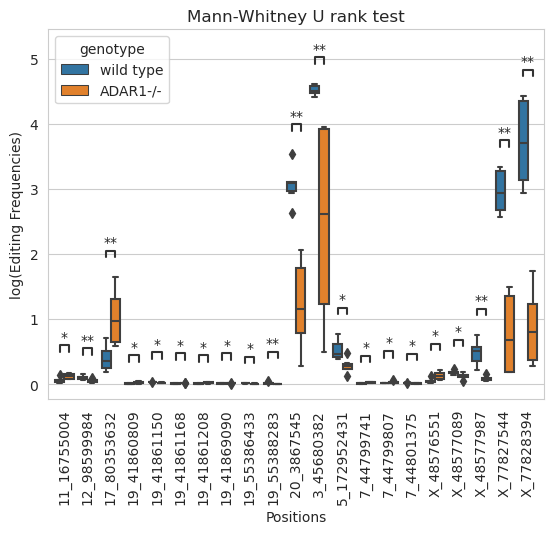

In [23]:
ax = a2i.plot.boxplot(df, log_scale=True, pvalue_list=mw.values[0].tolist()[:-2], positions_to_plot=mw.columns.tolist()[:-2])
ax.set_title('Mann-Whitney U rank test')
plt.savefig('/mnt/d/GoTx_Folder/draft/FIG2B_MW.pdf', format='pdf', dpi=300,bbox_inches='tight')

## Statistics for porprotions

### Pooling smaples/coordinates by G-test

In [24]:
a, g = a2i.editing.pool_positions(df_a[df.columns],df_g[df.columns])

In [20]:
a

,11_16744616,11_16748108,11_16752815,11_16752839,11_16752876,11_16755004,12_132769626,12_64421327,12_64439300,12_98597857,...,X_48576328,X_48576551,X_48576569,X_48577089,X_48577487,X_48577626,X_48577946,X_48578090,region,genotype
genotype,,,,,,,,,,,,,,,,,,,,,
ADAR1-/-,21389.0,24274.0,26952.0,27495.0,23534.0,23572.0,2.0,5647.0,4676.0,49063.0,...,31007.0,33980.0,37368.0,33850.0,25259.0,13276.0,26526.0,29461.0,several,ADAR1-/-
wild type,24607.0,26603.0,28564.0,29364.0,25691.0,25934.0,2.0,4443.0,4392.0,44439.0,...,28891.0,29916.0,32864.0,27261.0,17372.0,5198.0,23686.0,24636.0,several,wild type


In [21]:
g

,11_16744616,11_16748108,11_16752815,11_16752839,11_16752876,11_16755004,12_132769626,12_64421327,12_64439300,12_98597857,...,X_48576328,X_48576551,X_48576569,X_48577089,X_48577487,X_48577626,X_48577946,X_48578090,region,genotype
genotype,,,,,,,,,,,,,,,,,,,,,
ADAR1-/-,17.0,38.0,28.0,49.0,16.0,30.0,1166.0,48.0,20.0,51.0,...,20.0,47.0,86.0,43.0,33.0,37.0,21.0,170.0,several,ADAR1-/-
wild type,25.0,45.0,31.0,39.0,22.0,16.0,1200.0,42.0,29.0,37.0,...,35.0,12.0,79.0,54.0,37.0,23.0,16.0,115.0,several,wild type


In [25]:
chi = a2i.stats.chi2_test(a,g,only_pvalue=True,pvalue_filter_limit=.05)
chi

,11_16755004,12_98599984,15_44561843,19_41860835,19_41860843,19_41861150,19_41869033,19_41869717,19_55386571,19_55386578,...,5_172952431,7_44799741,7_44799807,7_44801292,7_44801505,X_48576328,X_48576551,X_48577089,region,genotype
pvalue,0.024408,0.004265,0.037467,0.037716,0.048953,0.030356,0.008368,0.041716,0.04406,0.030622,...,0.019568,0.013371,0.006147,0.025404,0.031881,0.030934,0.000043,0.037573,several,ADAR1-/-_vs_wild type


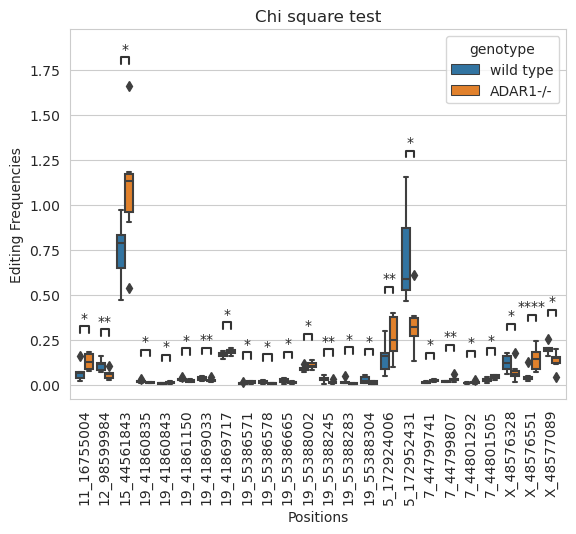

In [79]:
ax = a2i.plot.boxplot(df, log_scale=False, pvalue_list=chi.values[0].tolist()[:-2], positions_to_plot=chi.columns.tolist()[:-2])
ax.set_title('Chi square test')
plt.savefig('/mnt/d/GoTx_Folder/draft/FIG2A_chi2.pdf', format='pdf', dpi=300,bbox_inches='tight')

In [34]:
fis = a2i.stats.fisher_test(a,g,only_pvalue=True,pvalue_filter_limit=1)
fis

,11_16744616,11_16748108,11_16752815,11_16752839,11_16752876,11_16755004,12_132769626,12_64421327,12_64439300,12_98597857,...,X_48576328,X_48576551,X_48576569,X_48577089,X_48577487,X_48577626,X_48577946,X_48578090,region,genotype
pvalue,0.444844,0.742769,0.896941,0.199999,0.519128,0.018106,1.0,0.670001,0.152222,0.337001,...,0.029863,0.000035,0.814907,0.031661,0.050668,0.085161,0.742406,0.083754,several,ADAR1-/-_vs_wild type


In [35]:
or_ = a2i.editing.odds_r(a.loc[:,fis.columns], g.loc[:,fis.columns])
or_

,11_16744616,11_16748108,11_16752815,11_16752839,11_16752876,11_16755004,12_132769626,12_64421327,12_64439300,12_98597857,...,X_48576328,X_48576551,X_48576569,X_48577089,X_48577487,X_48577626,X_48577946,X_48578090,region,genotype
odds_ratio,1.278264,1.080535,1.044661,0.745263,1.25955,0.484766,1.029147,1.112103,1.543688,0.800981,...,1.878152,0.290008,1.044498,1.559334,1.630231,1.587615,0.853261,0.808962,several,ADAR1-/-_vs_wild type


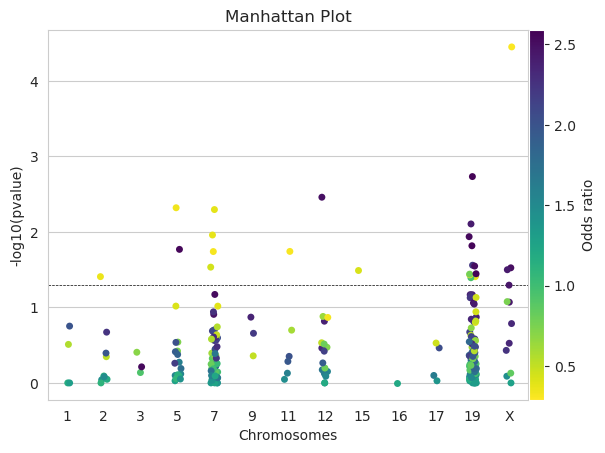

In [88]:
ax = a2i.plot.manhattanplot(or_, fis, p_value_line=0.05, chr_order=['1', '2', '3', '5', '7', '9', '11', '12','15', '16', '17', '19', 'X'])
ax.set_title('Manhattan Plot')
plt.savefig('/mnt/d/GoTx_Folder/draft/FIG2C_manhattanplot.pdf', format='pdf', dpi=300,bbox_inches='tight')

### Entropy calcluation

In [90]:
entr = a2i.stats.entropy_calculation(a,g)
entr

,11_16744616,11_16748108,11_16752815,11_16752839,11_16752876,11_16755004,12_132769626,12_64421327,12_64439300,12_98597857,...,X_48575266,X_48575279,X_48576328,X_48576551,X_48576569,X_48577089,X_48577487,X_48577626,X_48577946,X_48578090
ADAR1-/-,0.006463,0.011661,0.008168,0.013041,0.005635,0.009746,0.012618,0.048648,0.027498,0.008172,...,0.002930,0.009293,0.005380,0.010476,0.016246,0.009730,0.009970,0.019133,0.006441,0.035329
wild type,0.008010,0.012467,0.008485,0.010113,0.006899,0.005174,0.012309,0.053061,0.039512,0.006731,...,0.004042,0.009190,0.009337,0.003537,0.016863,0.014284,0.015202,0.028294,0.005603,0.029594


In [111]:
# # This is just to correct the order of the coordinates
# aux = pd.DataFrame([i.split('_') for i in entr.columns])
# aux_n = aux[aux[0]!='X']
# aux_x = aux[aux[0]=='X']

# aux_n.loc[:,0] = aux_n[0].astype(int)
# aux_n.loc[:,1] = aux_n[1].astype(int)
# aux_n = aux_n.sort_values([0,1])
# aux_n.loc[:,0] = aux_n[0].astype(str)
# aux_n.loc[:,1] = aux_n[1].astype(str)

# aux_x.loc[:,1] = aux_x[1].astype(int)
# aux_x = aux_x.sort_values(1)
# aux_x.loc[:,1] = aux_x[1].astype(str)

# aux = pd.concat([aux_n, aux_x])
# aux[2] = aux[0] + '_' + aux[1]

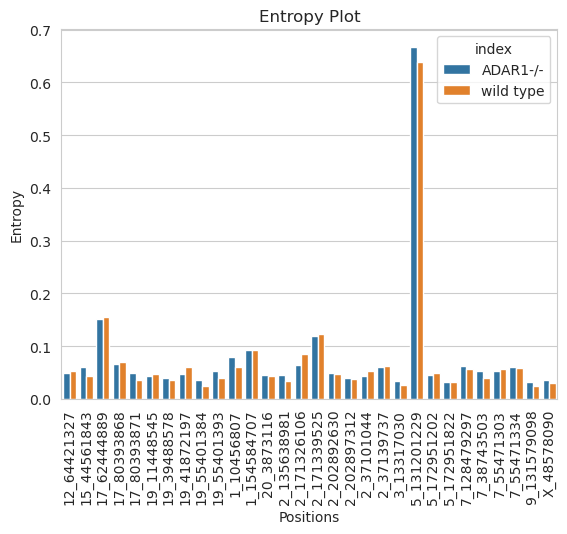

In [126]:
ax = a2i.plot.entropy_plot(entr, n_top=30)
ax.set_title('Entropy Plot')
plt.savefig('/mnt/d/GoTx_Folder/draft/FIG2D_entropy.pdf', format='pdf', dpi=300,bbox_inches='tight')

### Pearson correlation tests

In [26]:
pearson = a2i.stats.conditon_pearson_corr(df[chi.columns].fillna(0), return_only_significant=False ,pvalue_filter_limit=0.05)
pearson

,Positions,R,pvalue
0,11_16755004,-0.177720,0.736226
1,12_98599984,0.329284,0.523926
2,15_44561843,0.400999,0.430741
3,19_41860835,-0.447937,0.373033
4,19_41860843,-0.107692,0.839086
5,19_41861150,-0.244182,0.641007
6,19_41869033,0.335755,0.515292
7,19_41869717,0.377648,0.460457
8,19_55386571,0.278501,0.593050
9,19_55386578,-0.335177,0.516061


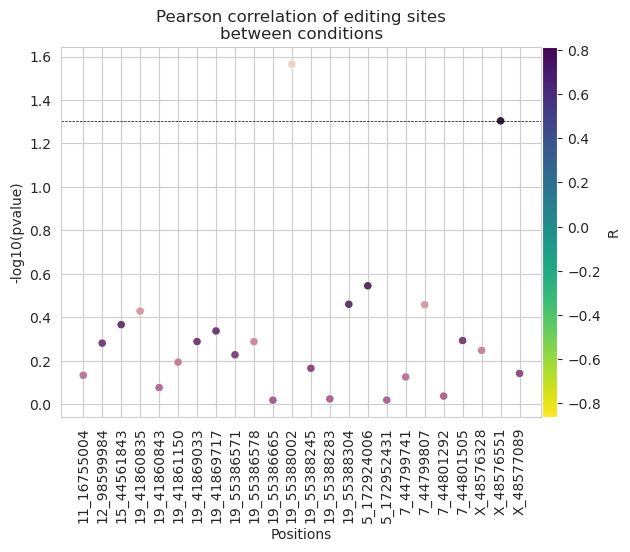

In [29]:
ax = a2i.plot.corr_pearson_plot(pearson, log_scale=True, p_value_line=0.05)
ax.set_title('Pearson correlation of editing sites\nbetween conditions')
plt.savefig('/mnt/d/GoTx_Folder/draft/FIG2E_corr.pdf', format='pdf', dpi=300,bbox_inches='tight')